## Import Libraries

In [1]:
import torch
import torch.nn as nn
import zipfile
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
from torchvision.models import AlexNet_Weights
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import numpy as np
import tqdm

## Using Seed for Replication
seed = 10


In [9]:
# Seed para replicar o modelo
SEED = 70
import random
random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

NameError: name 'np' is not defined

## Using Transforms and Loading Datasets

In [3]:
# Definir transformações
transformacao = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Carregar datasets
base_treinamento = datasets.ImageFolder(root='USK-Coffee/train', transform=transformacao)
train_dataloader = DataLoader(base_treinamento, batch_size=10, shuffle=True)

base_validacao = datasets.ImageFolder(root='USK-Coffee/val', transform=transformacao)
validation_dataloader = DataLoader(base_validacao, batch_size=10, shuffle=True)

base_teste = datasets.ImageFolder(root='USK-Coffee/test', transform=transformacao)
test_dataloader = DataLoader(base_teste, batch_size=1, shuffle=False)


## Creating Arquitecture

In [5]:
# Carregar modelo AlexNet pré-treinado com pesos atualizados
model = models.alexnet(weights=AlexNet_Weights.DEFAULT)

# Modificar para saída binária
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)  # Sem Sigmoid aqui


# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)


cuda


## Def Acc, Train and Evaluate Functions

In [24]:
def accuracy(outputs, labels):
    # Converta logits para probabilidades
    probs = torch.sigmoid(outputs)
    # Converta probabilidades para rótulos binários
    predicted = (probs >= 0.5).float()
    # Certifique-se de que labels também esteja no formato float
    labels = labels.float()
    # Calcule a proporção de acertos
    correct = (predicted == labels).sum().item()
    return correct / labels.numel()  # labels.numel() retorna o número total de elementos


    
# Definir loss function e otimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Função de treinamento
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += accuracy(outputs, labels.unsqueeze(1).float()).item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_accuracy = running_accuracy / len(loader.dataset)
    return epoch_loss, epoch_accuracy

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            # Enviar para dispositivo
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Obter previsões do modelo
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            predicted = (probs >= 0.5).float()
            
            # Calcular perda
            loss = criterion(outputs, labels.unsqueeze(1).float())
            running_loss += loss.item() * inputs.size(0)
            
            # Calcular acurácia
            correct = (predicted == labels.unsqueeze(1).float()).sum().item()
            total_correct += correct
            total_samples += inputs.size(0)
            
            # Diagnóstico
            print(f"Batch size: {inputs.size(0)}, Correct: {correct}, Total samples: {total_samples}")

    epoch_loss = running_loss / total_samples
    epoch_accuracy = total_correct / total_samples
    return epoch_loss, epoch_accuracy





## Def Checkpoint functions

In [7]:
class CustomModelCheckpoint:
    def __init__(self):
        self.best_val_accuracy = 0.0

    def __call__(self, epoch, val_accuracy, model, optimizer, loss):
        if val_accuracy > self.best_val_accuracy:
            print(f"Validation accuracy improved from {self.best_val_accuracy:.4f} to {val_accuracy:.4f}. Saving model...")
            self.best_val_accuracy = val_accuracy
            save_checkpoint(epoch, model, optimizer, loss)
            # Também salva o melhor modelo com um nome fixo
            save_best_model(model, optimizer, loss)

# Função para salvar checkpoint
def save_checkpoint(epoch, model, optimizer, loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, checkpoint_path.format(epoch=epoch))

# Função para salvar o melhor modelo
def save_best_model(model, optimizer, loss):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, best_model_path)

# Configurações de checkpoint
checkpoint_dir = "modelos/pesos_Alexnet"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'cp2-{epoch:04d}.pth')
best_model_path = os.path.join(checkpoint_dir, 'Melhor_modelo_Alexnet.pth')
cp_callback = CustomModelCheckpoint()

## Training Model

In [8]:
# Listas para guardar os valores de acuracia e loss do modelo
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 100  # mudar para a quantidade de épocas que desejar

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, validation_dataloader, criterion)

    # Adiciona loss e acurácia de treinamento e validação de cada época em uma lista
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    cp_callback(epoch, val_accuracy, model, optimizer, val_loss)


Epoch 1/100, Train Loss: 0.3255, Train Acc: 0.8542, Val Loss: 0.2286, Val Acc: 0.9012
Validation accuracy improved from 0.0000 to 0.9012. Saving model...
Epoch 2/100, Train Loss: 0.1892, Train Acc: 0.9288, Val Loss: 0.2366, Val Acc: 0.9137
Validation accuracy improved from 0.9012 to 0.9137. Saving model...
Epoch 3/100, Train Loss: 0.1420, Train Acc: 0.9442, Val Loss: 0.1979, Val Acc: 0.9325
Validation accuracy improved from 0.9137 to 0.9325. Saving model...
Epoch 4/100, Train Loss: 0.1273, Train Acc: 0.9492, Val Loss: 0.2896, Val Acc: 0.8975
Epoch 5/100, Train Loss: 0.1136, Train Acc: 0.9538, Val Loss: 0.1926, Val Acc: 0.9237
Epoch 6/100, Train Loss: 0.0964, Train Acc: 0.9633, Val Loss: 0.2220, Val Acc: 0.9313
Epoch 7/100, Train Loss: 0.0846, Train Acc: 0.9725, Val Loss: 0.2096, Val Acc: 0.9300
Epoch 8/100, Train Loss: 0.1083, Train Acc: 0.9600, Val Loss: 0.1665, Val Acc: 0.9400
Validation accuracy improved from 0.9325 to 0.9400. Saving model...
Epoch 9/100, Train Loss: 0.0672, Train A

## Plotting Acc and Loss Graphics

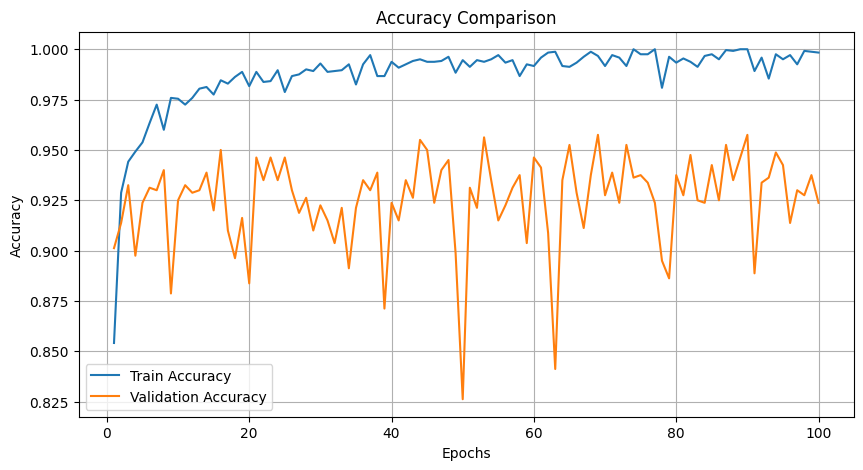

In [9]:
# Plotar acurácia
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)
output_dir = 'gráficos/Gráficos Alexnet'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, f'accuracy_comparison.pdf'))
plt.show()

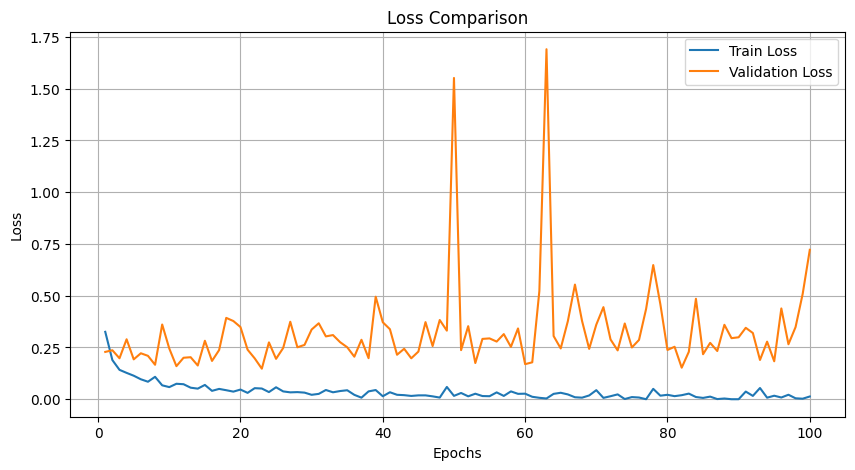

In [10]:
# Plotar perda
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, f'loss_comparison.pdf'))
plt.show()

## Testing Best Model

In [11]:
from torch.utils.data import DataLoader, Subset

transformacao = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Carregar datasets
base_treinamento = datasets.ImageFolder(root='USK-Coffee/train', transform=transformacao)
train_dataloader = DataLoader(base_treinamento, batch_size=10, shuffle=True)

base_validacao = datasets.ImageFolder(root='USK-Coffee/val', transform=transformacao)
validation_dataloader = DataLoader(base_validacao, batch_size=10, shuffle=True)

base_teste = datasets.ImageFolder(root='USK-Coffee/test', transform=transformacao)
test_dataloader = DataLoader(base_teste, batch_size=1, shuffle=False)



# Carregar modelo AlexNet pré-treinado com pesos atualizados
model = models.alexnet(weights=AlexNet_Weights.DEFAULT)

# Modificar para saída binária
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)  # Sem Sigmoid aqui

# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Carregar pesos do modelo pré-treinado
checkpoint = torch.load('modelos/pesos_Alexnet/Melhor_modelo_Alexnet.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Avaliar o modelo
val_loss, val_accuracy = evaluate(model, validation_dataloader, criterion)
print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}") # conferir se bateu com a melhor acurácia


cuda
Val Loss: 0.1824, Val Acc: 0.9550


In [12]:
'''
model.eval()

y_true = []
y_pred = []
y_scores = []

with torch.no_grad():  # desativa a mudança do modelo
    for inputs, labels in validation_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = outputs.squeeze().cpu().numpy()
        predicted = torch.round(outputs).squeeze().cpu().numpy()
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.tolist())
        y_scores.append(probs.tolist())
    val_loss, val_accuracy = evaluate(model, validation_dataloader, criterion)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")



conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Premium', 'Defect'], rotation=45)
plt.yticks(tick_marks, ['Premium', 'Defect'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
plt.tight_layout()
plt.show()

'''



'\nmodel.eval()\n\ny_true = []\ny_pred = []\ny_scores = []\n\nwith torch.no_grad():  # desativa a mudança do modelo\n    for inputs, labels in validation_dataloader:\n        inputs, labels = inputs.to(device), labels.to(device)\n        outputs = model(inputs)\n        probs = outputs.squeeze().cpu().numpy()\n        predicted = torch.round(outputs).squeeze().cpu().numpy()\n        y_true.append(labels.cpu().numpy())\n        y_pred.append(predicted.tolist())\n        y_scores.append(probs.tolist())\n    val_loss, val_accuracy = evaluate(model, validation_dataloader, criterion)\n    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")\n\n\n\nconf_matrix = confusion_matrix(y_true, y_pred)\nplt.figure(figsize=(8, 6))\nplt.imshow(conf_matrix, interpolation=\'nearest\', cmap=plt.cm.Blues)\nplt.title(\'Confusion Matrix\')\nplt.colorbar()\ntick_marks = np.arange(2)\nplt.xticks(tick_marks, [\'Premium\', \'Defect\'], rotation=45)\nplt.yticks(tick_marks, [\'Premium\', \'Defect\'])\n

# Testing Model

In [25]:
# Inicialize como listas vazias
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Aplique Sigmoid para converter logits em probabilidades
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        
        # Converta probabilidades em rótulos binários
        predicted = (probs >= 0.5).astype(int)
        
        # Acumule os valores verdadeiros, previstos e probabilidades
        y_true.extend(labels.cpu().numpy().flatten().tolist())
        y_pred.extend(predicted.flatten().tolist())
        y_scores.extend(probs.flatten().tolist())

    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

# Após o loop, você pode converter para arrays NumPy, se necessário
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


Batch size: 1, Correct: 1, Total samples: 1
Batch size: 1, Correct: 1, Total samples: 2
Batch size: 1, Correct: 1, Total samples: 3
Batch size: 1, Correct: 1, Total samples: 4
Batch size: 1, Correct: 1, Total samples: 5
Batch size: 1, Correct: 1, Total samples: 6
Batch size: 1, Correct: 1, Total samples: 7
Batch size: 1, Correct: 1, Total samples: 8
Batch size: 1, Correct: 1, Total samples: 9
Batch size: 1, Correct: 1, Total samples: 10
Batch size: 1, Correct: 1, Total samples: 11
Batch size: 1, Correct: 1, Total samples: 12
Batch size: 1, Correct: 1, Total samples: 13
Batch size: 1, Correct: 1, Total samples: 14
Batch size: 1, Correct: 1, Total samples: 15
Batch size: 1, Correct: 1, Total samples: 16
Batch size: 1, Correct: 1, Total samples: 17
Batch size: 1, Correct: 1, Total samples: 18
Batch size: 1, Correct: 1, Total samples: 19
Batch size: 1, Correct: 1, Total samples: 20
Batch size: 1, Correct: 1, Total samples: 21
Batch size: 1, Correct: 1, Total samples: 22
Batch size: 1, Corr

## Plotting Confusion Matrix and Precision Recall Graphic

Confusion Matrix:
 [[361  39]
 [ 29 371]]
Matrix Accuracy: 0.9150


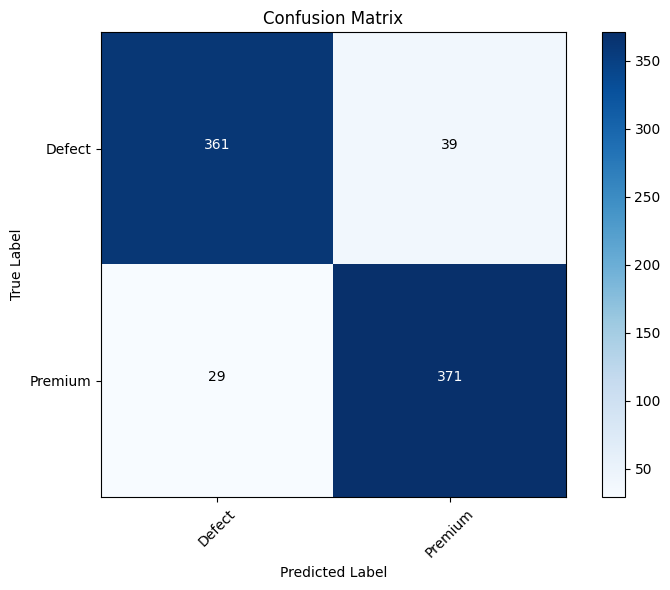

Manual Accuracy: 0.9150


In [28]:
# Converta para arrays NumPy
y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)
y_scores = np.array(y_scores)

# Calcule a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Print matriz e acurácia derivada da matriz
print("Confusion Matrix:\n", conf_matrix)
matrix_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Matrix Accuracy: {matrix_accuracy:.4f}")

# Visualize a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Defect', 'Premium'], rotation=45)
plt.yticks(tick_marks, ['Defect', 'Premium'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adicione valores na matriz
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'confusion_matrix.pdf'))
plt.show()

# Calcule a acurácia manualmente
manual_accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Manual Accuracy: {manual_accuracy:.4f}")


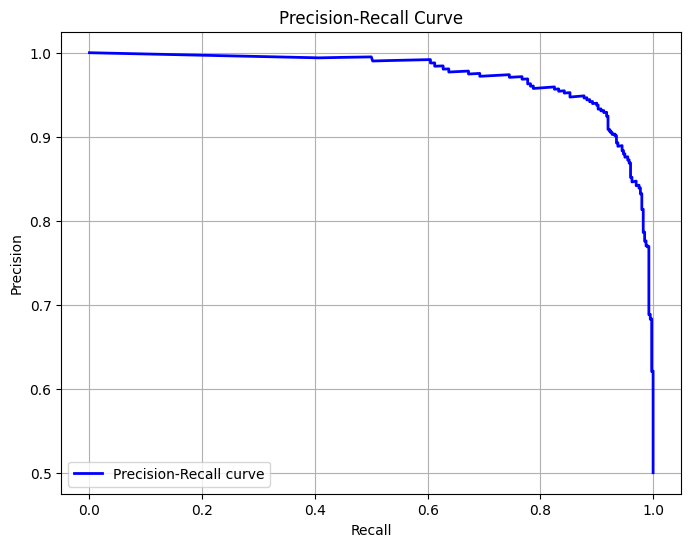

Melhor pontuação F1: 0.9232704402515722
Valor de recall no ponto F1 máximo: 0.9175


In [31]:
from sklearn.metrics import precision_recall_curve, f1_score

# precision_recall_curve retorna precisão, recall e os thresholds
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

# Calcula a pontuação F1
f1 = 2 * (precision * recall) / (precision + recall)

# Encontre o índice do ponto de F1 máximo
idx = np.argmax(f1)

# Extrair o melhor valor de recall no ponto de F1 máximo
best_f1 = f1[idx]
best_recall = recall[idx]

plt.savefig(os.path.join(output_dir, f'Precision-Recall.pdf'))

plt.show()

# Exibe a melhor pontuação F1 e o valor de recall correspondente
print("Melhor pontuação F1:", best_f1)
print("Valor de recall no ponto F1 máximo:", best_recall)